Script to show how event locations are found based on the prediction trace. The interactive plot at the end of the script can also be used to identify an appropriate size for the Hann window (convolve_win).

In [6]:
import sys
sys.path.append('../../core/') # Needed to import miniML from another folder.
from miniML import MiniTrace, EventDetection


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import resample
from scipy import signal
from scipy.signal import find_peaks
from scipy.ndimage import maximum_filter1d



import matplotlib
%matplotlib inline

We will need the detection trace generated by miniML. Let's run the inference without downtream event analysis (eval=False in detection.detect_events()). We can then access the prediction via detection.prediction later on.

In [7]:
filename = '../../example_data/gc_mini_trace.h5'
scaling = 1e12
unit = 'pA'

# get from h5 file
trace = MiniTrace.from_h5_file(filename=filename,
                               tracename='mini_data',
                               scaling=scaling,
                               unit=unit)


model = '../../model/GC_lstm_model.h5'
win_size = 600
threshold = 0.5
event_direction='negative'
training_direction='negative'


detection = EventDetection(data=trace,
                           model_path=model,
                           window_size=win_size,
                           model_threshold=threshold,
                           batch_size=512,
                           event_direction=event_direction,
                           training_direction=training_direction,
                           compile_model=True)

detection.detect_events(eval=False, verbose=True)



Data loaded from ../../example_data/gc_mini_trace.h5 with shape (6000000,)
Model loaded from ../../model/GC_lstm_model.h5
586/586 [==============================] - 15s 25ms/step


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Next, we filter the obtained prediction trace with a maximum filter and apply a peak finding algorithm. Below, the data and values for win_size etc. are adjusted using a resampling factor. This is based on the indicated window_size and necessary for transfer learning. Based on the detected peaks in the detection, we cut out a time window that should contain the event of interest (i.e. the window between start_pnts and end_pnts). for clarity, the start- and end-points are shown below.

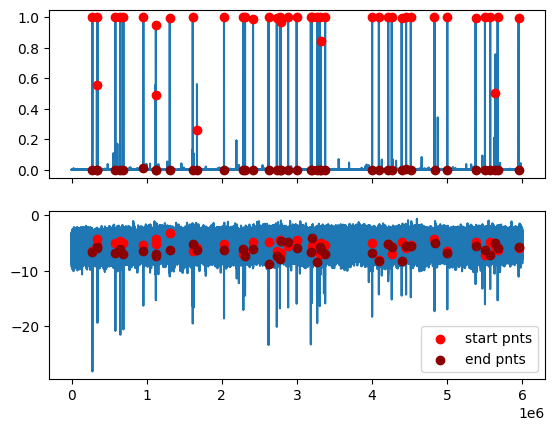

In [8]:
%matplotlib inline

win_size = int(detection.window_size*detection.resampling_factor)
stride = int(detection.stride_length*detection.resampling_factor)
sampling = detection.trace.sampling/detection.resampling_factor
add_points = int(win_size/3)
limit=win_size + add_points

filtered_prediction = maximum_filter1d(detection.prediction, size=5, origin=-2)
_, peak_properties = find_peaks(x=filtered_prediction, height=detection.model_threshold, 
                                prominence=detection.model_threshold, width=detection.peak_w)

start_pnts = np.array(peak_properties['left_ips'] * stride + win_size/4, dtype=np.int64)
end_pnts =  np.array(peak_properties['right_ips'] * stride + win_size/2, dtype=np.int64)
prediction_x = np.arange(0, len(filtered_prediction)) * detection.stride_length


fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(prediction_x, filtered_prediction)
axs[0].scatter(x=start_pnts, y=filtered_prediction[(start_pnts/stride).astype(int)], c='red', zorder=2)
axs[0].scatter(x=end_pnts, y=filtered_prediction[(end_pnts/stride).astype(int)], c='darkred', zorder=2)


axs[1].plot(trace.data)
axs[1].scatter(x=start_pnts, y=trace.data[start_pnts], c='red', zorder=2, label='start pnts')
axs[1].scatter(x=end_pnts, y=trace.data[end_pnts], c='darkred', zorder=2, label='end pnts')
axs[1].legend()
plt.show()

Now we can identify the position of steepest rise within the the data stretches using the first derivative. Because we use a derivative-based approach we need to filter the data to avoid finding noise peaks:
- Filter the raw data.
- Find the first the derivative of the filtered data.
- Filter the first derivative again using the same filter settings

To filter the data we use a Hann window. We only need to set one parameter, the window size.


In the filtered first derivative, we can the again use a peak finding algorithm. We use a threshold of 4 * the standard deviation of the noise (event free datastreches) to identify peaks. This is also used to identify overlapping events. If multiple peaks are found in the first derivative, peaks that have a prominence of 0.25 relative to the highest prominence (rel_prom_cutoff, can be adjusted if necessary) are treated as additional events in the same window. See also https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_prominences.html for more details.

This also means that the filter settings may need to be adjusted depending on the preparation. This can be done by making the plot at the end of the script interactive (%matplotlib qt, see below). In the documentation, there are two examples for cerebellar granule cells that illustrate what we consider to be good filter settings.

In [9]:
convolve_win = 20 # Size of the Hann window. Once you have determined which value works well for your data, you can use it in detection.detect_events()
rel_prom_cutoff = 0.25 # cutoff for multiple peaks. See below

win = signal.windows.hann(convolve_win)

# set all values for resampling traces
data_trace = resample(detection.trace.data, int(len(detection.trace.data)*detection.resampling_factor))
data_trace *= detection.event_direction # (-1 if 'negative', 1 else)


# filter raw data trace, calculate gradient and filter first derivative trace
trace_convolved = signal.convolve(data_trace, win, mode='same') / sum(win)
gradient = np.gradient(trace_convolved, sampling)
smth_gradient = signal.convolve(gradient, win, mode='same') / sum(win)

# get threshold based on standard deviation of the derivative of event-free data sections
split_data = np.split(smth_gradient, np.vstack((start_pnts, end_pnts)).ravel('F'))
event_free_data = np.concatenate(split_data[::2]).ravel()
threshold = int(4 * np.std(event_free_data))


event_locations, event_scores = [], []
for i, position in enumerate(peak_properties['right_ips'] * stride): 
    if position < win_size:
        continue
    peaks, peak_params = find_peaks(x=smth_gradient[start_pnts[i]:end_pnts[i]], height=threshold, 
                        prominence=threshold)
    

    if peaks.shape[0] > 1: # If > 1 peak found; apply relative prominence cutoff of .25
        rel_prom = peak_params['prominences']/np.max(peak_params['prominences'])
        inds = np.where(rel_prom >= rel_prom_cutoff)[0] # .25 is default value for relative prominence cutoff.: can be adjusted by setting a different value in detection.detect_events()  
        peaks = peaks[inds]
        for my_param in peak_params:
            peak_params[my_param] = peak_params[my_param][inds]
    
    if not len(peaks): # If no peak found: default argmax finding
        peaks = np.array([np.argmax(smth_gradient[start_pnts[i]:end_pnts[i]])])

    for peak in peaks:
        if (start_pnts[i] + peak) >= (data_trace.shape[0] - limit):
            continue
        if start_pnts[i] + peak not in event_locations:
            event_locations.append(start_pnts[i] + peak)
            event_scores.append(peak_properties['peak_heights'][i])

### Check for duplicates:
if np.array(event_locations).shape[0] != np.unique(np.array(event_locations)).shape[0]:
    print('removed duplicates')

event_locations = np.unique(np.array(event_locations))
num_locations = event_locations.shape[0]

remove = []
for ind, i in enumerate(event_locations):
    close = event_locations[np.isclose(i, event_locations, atol=win_size/100)]
    if close.shape[0] > 1:
        for ind, removal in enumerate(close):
            if ind > 0:
                remove.append(removal)
remove = np.unique(np.array(remove))
for i in remove:
    event_locations = event_locations[np.where(event_locations != i)[0]]

if event_locations.shape[0] != num_locations:
    print('removed event locations via atol criterium')

event_locations = (event_locations / detection.resampling_factor).astype(int)

Now we can plot the output. %matplotlib qt makes the plot interactive. This allows zooming into the data to see how the trace and the derivative are looking. If the filter is not satisfactory, adjust convolve_win at the beginning of the cell above, and run again.

In [11]:
%matplotlib qt

fig, axs = plt.subplots(3, 1, sharex=True)


axs[0].plot(prediction_x, filtered_prediction)
axs[0].scatter(x=start_pnts, y=filtered_prediction[(start_pnts/stride).astype(int)], c='red', zorder=2, label='start pnts')
axs[0].scatter(x=end_pnts, y=filtered_prediction[(end_pnts/stride).astype(int)], c='darkred', zorder=2, label='end pnts')

axs[0].set_title('miniML prediction')
axs[0].legend(loc="right")


axs[1].plot(data_trace, alpha=0.5, c='k')
axs[1].plot(trace_convolved)
axs[1].scatter(event_locations, trace_convolved[event_locations], c='orange', zorder=2, label='event locations')
axs[1].scatter(x=start_pnts, y=data_trace[start_pnts], c='red', zorder=2, label='start pnts')
axs[1].scatter(x=end_pnts, y=data_trace[end_pnts], c='darkred', zorder=2, label='end pnts')

axs[1].legend(loc="right")
axs[1].set_title('trace (grey) + filtered trace (blue)')


axs[2].plot(gradient, alpha=0.5, c='k')
axs[2].plot(smth_gradient)
axs[2].scatter(event_locations, smth_gradient[event_locations], c='orange', zorder=2, label='event locations')
axs[2].scatter(x=start_pnts, y=smth_gradient[start_pnts], c='red', zorder=2, label='start pnts')
axs[2].scatter(x=end_pnts, y=smth_gradient[end_pnts], c='darkred', zorder=2, label='end pnts')

axs[2].axhline(threshold, c='orange', ls='--')


axs[2].legend(loc="right")
axs[2].set_title('gradient (grey)+ filtered gradient (blue)')

plt.tight_layout()
plt.show()